In [27]:
!jupyter-nbconvert --to python --template python_clean Layout.ipynb

[NbConvertApp] Converting notebook Layout.ipynb to python
[NbConvertApp] Writing 13895 bytes to Layout.py


In [311]:
%load_ext autoreload
%autoreload 2

%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [249]:
import logging
from pathlib import Path
import copy
from PIL import Image, ImageDraw, ImageFont

In [250]:
try:
    from . import constants
    from . import version
except ImportError as e:
    import constants
    import version
    
    
try: 
    from . import Block as Block
except ImportError as e:
    import Block as Block

In [251]:
logger = logging.getLogger(__name__)

In [252]:
def strict_enforce(*types):
    """strictly enforce type compliance within classes
    
    Usage:
        @strict_enforce(type1, type2, (type3, type4))
        def foo(val1, val2, val3):
            ...
    """
    def decorator(f):
        def new_f(self, *args, **kwds):
            #we need to convert args into something mutable   
            newargs = []        
            for (a, t) in zip(args, types):
                if not isinstance(a, t):
                    raise TypeError(f'"{a}" is not type {t}')
#                 newargs.append( t(a)) #feel free to have more elaborated convertion
            return f(self, *args, **kwds)
        return new_f
    return decorator

In [312]:
class Layout:
    def __init__(self, resolution, layout=None, force_onebit=False):
        self.resolution = resolution
        self.force_onebit = force_onebit
        self.mode = '1'
        self.blocks = {}
        self.layout = layout
        
        
    
    @property
    def resolution(self):
        return self._resolution
    
    @resolution.setter
    @strict_enforce((list, tuple))
    def resolution(self, resolution):
        for i in resolution:
            if i < 0 or not isinstance(i, int):
                raise ValueError(f'resolution values must be positive integers: {resolution}')
        
        self._resolution = resolution
        
    @property
    def layout(self):
        return self._layout
    
    @layout.setter
    @strict_enforce((dict, type(None)))
    def layout(self, layout):
        self._layout = layout
        
        if self._layout:
            self._add_defaults()
            self._calculate_layout()
            self._set_blocks()
    
    def _set_blocks(self):
        if not self.layout:
            return
        
        logging.info('setting blocks')
        blocks = {}
        mode_count = 0
        
        for section, vals in self.layout.items():
            logging.info(f'section: [{section:_^30}]')
            
            if self.force_onebit:
                vals['mode'] = '1'
                logging.debug('forcing block to 1bit mode')
            
            logging.debug(f'setting block type: {vals["type"]}')
            try:
                blocks[section] = getattr(Block, vals['type'])(**vals)

            except AttributeError:
                raise AttributeError(f'module "Block" has no attribute {vals["type"]}. error in section: {section}')
              
            if vals['mode'] == 'L':
                mode_count += 1
                
            if mode_count > 0:
                self.mode = 'L'
            else:
                self.mode = '1'
                
            self.blocks = blocks
    
    
    def _add_defaults(self):
        logging.debug('checking default values for layout')
        for section, values in self.layout.items():
            logging.debug(f'section: [{section:-^30}]')
            if not 'type' in values:
                raise KeyError(f'section "{section}" is missing key "type"! Each section in the layout must have the correct block type')
            else:
                my_type = values['type']
                
            try:
                my_defaults = getattr(constants, f'LAYOUT_{my_type.upper()}_DEFAULTS')
            except AttributeError:
                raise ModuleNotFoundError(f'"Block" objects do not have a block type "{my_type}"')
            
            ### add kludge to bridge between 0.5 and 0.6 -- temporarily allow no type and guess 
            
            for key, default in my_defaults.items():
                if not key in values:
                    values[key] = default
                    logging.debug(f'adding "{key}: {default}"')
            
            for key, default in constants.LAYOUT_DEFAULTS.items():
                if not key in values:
                    values[key] = default
                    logging.debug(f'adding "{key}: {default}"')
                    
            self.layout[section] = values
    
    def _calculate_layout(self):
        if not self._layout:
            return
        
        
        logging.debug('calculating layouts')
        for section, values in self.layout.items() :
            logging.info(f'section: [{section:.^30}]')
            
            # calculate absolute area and padded area of each block

            area = (round(self.resolution[0]*values['width']), 
                    round(self.resolution[1]*values['height']))
            
            padded_area = (area[0] - (2* values['padding']),
                           area[1] - (2* values['padding']))
    
            values['area'] = area
            values['padded_area'] = padded_area
            
            if values['type'] == 'TextBlock':
                values['font_size'] = self._scale_font(values)
            
            
            if values['abs_coordinates'][0] is None or values['abs_coordinates'][1] is None:
                logging.debug('calculating block position from relative positions')
                pos = [None, None]
                for index, val in enumerate(values['relative']):
                    # use the absolute value provided in this section
                    if val == section:
                        pos[index] = values['abs_coordinates'][index]
                    else:
                        # calculate position relative to another block
                        try:
                            pos[index] = self.layout[val]['area'][index] + self.layout[val]['abs_coordinates'][index]
                        except KeyError:
                            raise KeyError(f'bad relative section value: "{value}" in section "{section}" could not be found')
                values['abs_coordinates'] = (pos[0], pos[1])
            else: 
                logging.debug('absolute coordinates provided')
            
            logging.debug(f'block coordinates: {values["abs_coordinates"]}')
            
       
                
    def _scale_font(self, this_section):
        text = constants.LAYOUT_SCALE_FONT_TEXT
        logging.debug('scaling font size')
        x_target, y_target = this_section['padded_area']
        
        y_target = y_target/this_section['max_lines']
        font = this_section['font']        
        
        cont = True
        fontsize = 0
        while cont:
            fontsize += 1
            testfont = ImageFont.truetype(font, fontsize)
            
            fontdim = testfont.getsize(text)
            
            if fontdim[0] > x_target:
                cont = False
                logging.debug('x target size reached')
            
            if fontdim[1] > y_target:
                cont = False
                logging.debug('y target size reached')
            
        fontsize -= 1
        logging.debug(f'calculated font size: {fontsize}')
        return fontsize
    
    
    def update_contents(self, update=None):
        if not update:
            return
        
        if not isinstance(update, dict):
            raise TypeError('update must be of type `dict`')
        
        for key, val in update.items():
            if key in self.blocks:
                self.blocks[key].update(val)
            else:
                logging.debug(f'"{key}" is not a recognized block, skipping')
                
    def concat(self):
        self.image = Image.new('L', self.resolution, 255)
        if self.blocks:
            for b in self.blocks:
                self.image.paste(self.blocks[b].image, self.blocks[b].abs_coordinates)
        return self.image    

DEBUG:root:checking default values for layout
DEBUG:root:section: [---------weather_img----------]
DEBUG:root:adding "inverse: False"
DEBUG:root:adding "dimensions: None"
DEBUG:root:adding "fill: 0"
DEBUG:root:section: [---------temperature----------]
DEBUG:root:adding "maxchar: None"
DEBUG:root:adding "inverse: False"
DEBUG:root:adding "dimensions: None"
DEBUG:root:adding "fill: 0"
DEBUG:root:section: [-------------wind-------------]
DEBUG:root:adding "maxchar: None"
DEBUG:root:adding "inverse: False"
DEBUG:root:adding "dimensions: None"
DEBUG:root:adding "mode: 1"
DEBUG:root:adding "fill: 0"
DEBUG:root:adding "bkground: 255"
DEBUG:root:section: [-------------rain-------------]
DEBUG:root:adding "maxchar: None"
DEBUG:root:adding "inverse: False"
DEBUG:root:adding "dimensions: None"
DEBUG:root:adding "mode: 1"
DEBUG:root:adding "fill: 0"
DEBUG:root:adding "bkground: 255"
DEBUG:root:section: [-----------h_line_1-----------]
DEBUG:root:adding "valign: center"
DEBUG:root:adding "halign: c

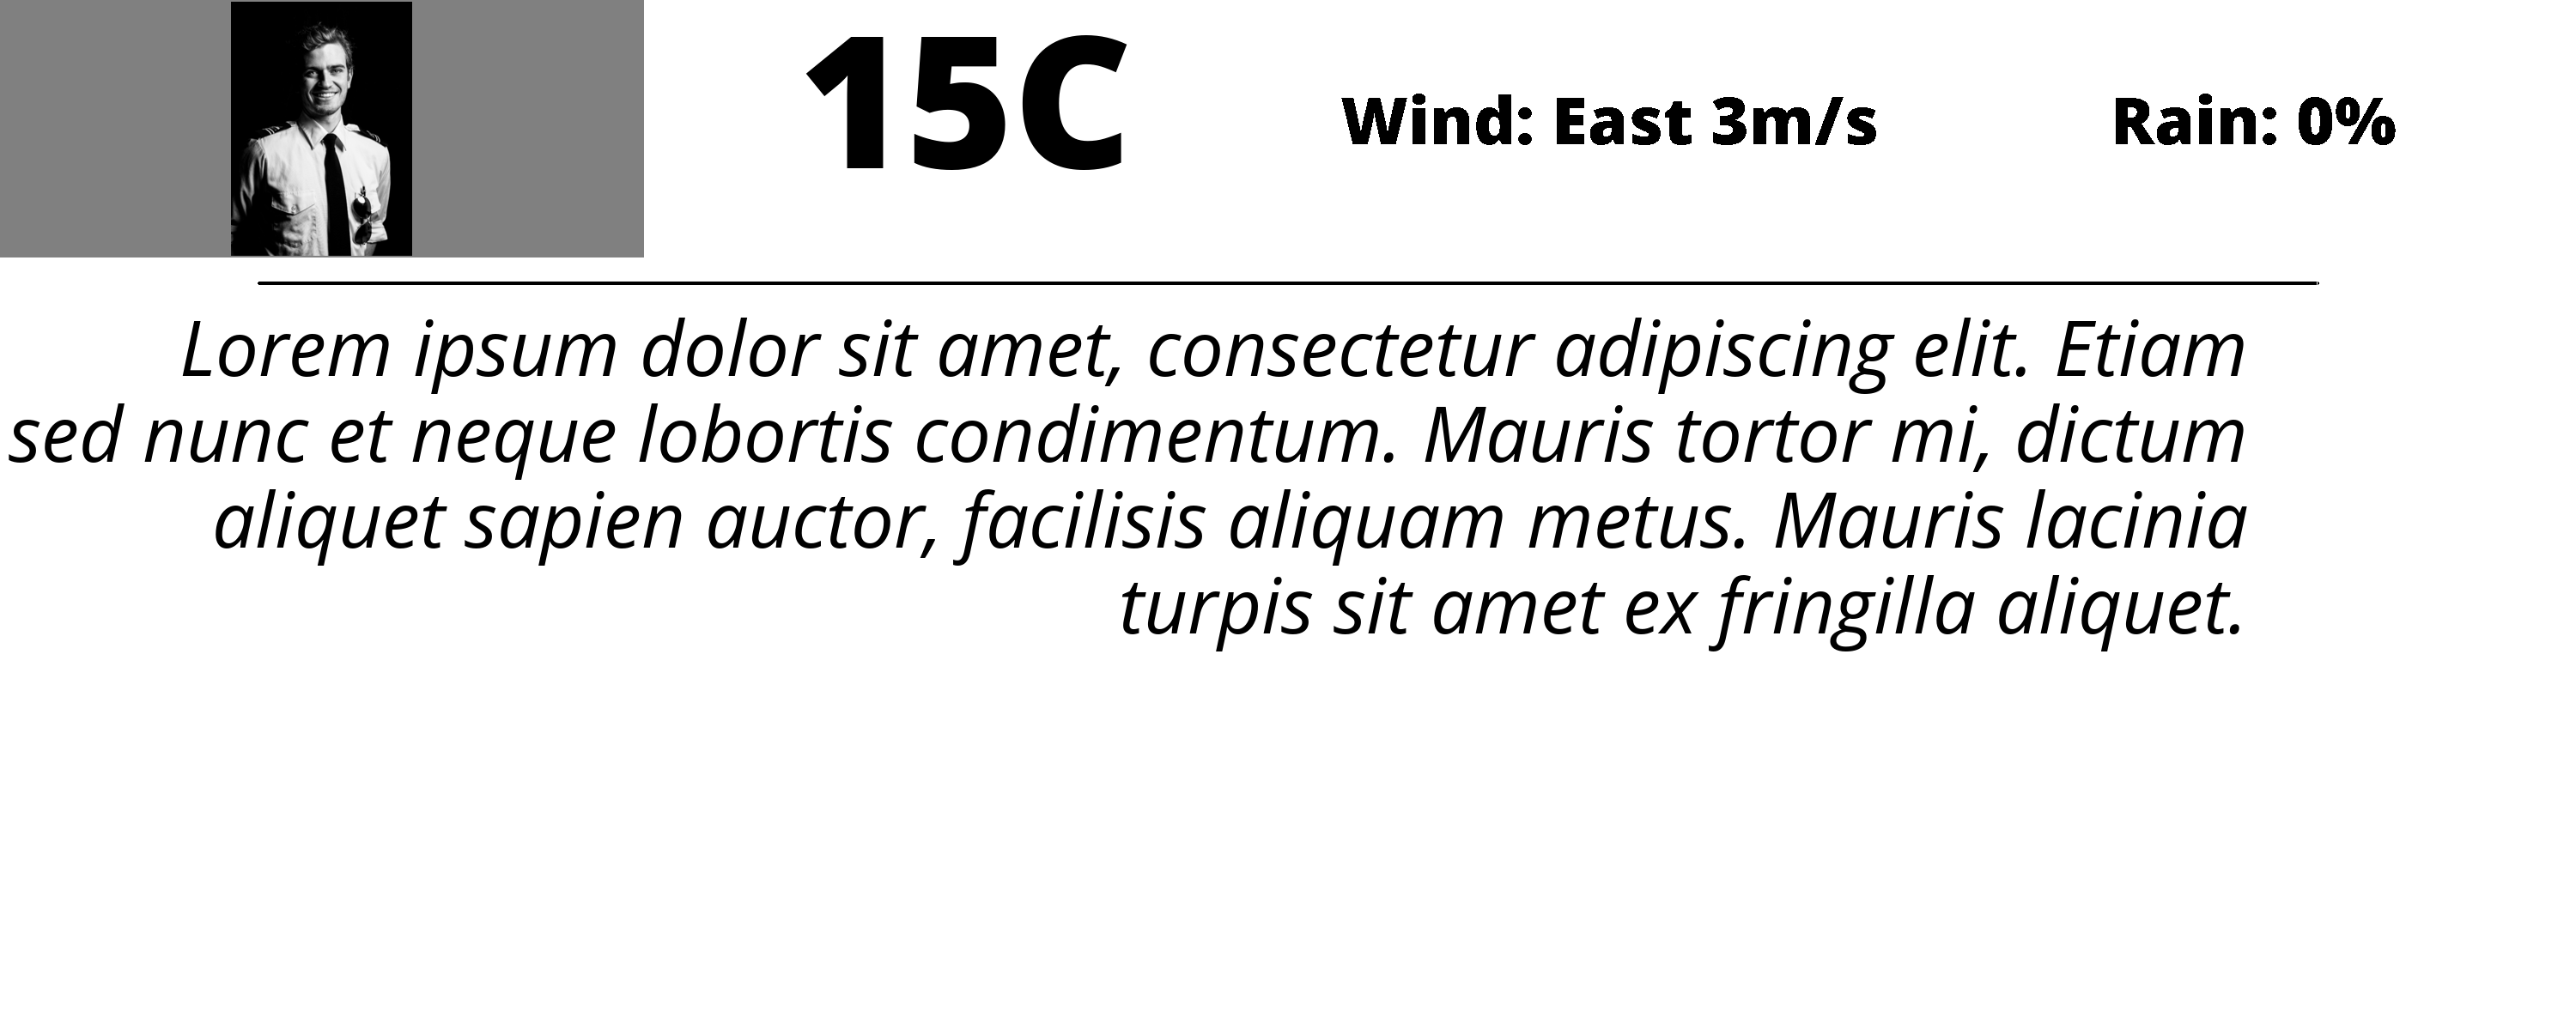

In [332]:
use_layout = deepcopy(l)
my_l = Layout(resolution=(3000, 1200), layout=use_layout)
my_l.update_contents(update)

my_l.concat()

In [314]:
q = my_l.blocks['h_line_1']

In [319]:
q.draw_image()

DEBUG:root:pixel_size: (720, 15)
DEBUG:root:alignment: h=center, v=center
INFO:root:no_clip: forcing shape inside bounds of area if necessary
DEBUG:root:box coordinates: [40, 7, 760, 22]


In [320]:
q.image

In [74]:
class xLayout:
    def __init__(self, resolution, layout=None, force_onebit=False):
        '''init layout object
        
        Args:
            resolution(tuple of int): X, Y screen resolution
            layout(dict): layout rules
            force_onebit(bool): override the mode setting of any block and force to 1bit mode
                This can improve the appearnce of anti-aliased fonts on 1bit screens
            
        Attributes:
            blocks(dict of Block obj): dictionary of ImageBlock and TextBlock objects
            screen(PIL.Image): single image composed of all blocks defined in the layout
            mode(str): "L" (8bit) or "1" (1bit) if any blocks are 8bit, this will be set to "L"'''
        
        self.resolution = resolution
        self.force_onebit = force_onebit
        self.screen = None
        self.mode = "1"
        self.layout = layout
        self._calculate_layout()
        self._set_blocks()

    @property
    def resolution(self):
        '''tuple of int: absolute resolution of screen'''
        return self._resolution

    @resolution.setter
    @strict_enforce((list, tuple))
    def resolution(self, resolution):
        for i in resolution:
            if i < 0:
                raise ValueError('resolution values must be positive integers')

            if not isinstance(i, int):
                raise ValueError('resolution values must be positive integers')

        self._resolution = resolution

    @property
    def layout(self):
        return self._layout
    
    @layout.setter
    @strict_enforce((dict, type(None)))
    def layout(self, layout):
        self._layout = layout
        
        if layout:
            self._calculate_layout()
            self._set_blocks()
            
    def _set_blocks(self):
        '''create dictionary of all image blocks using the specified layout
        
        Sets:
            blocks(dict of Block): dictionary of all the blocks from the layout
            mode(str): "L" if any single block is 8bit mode, "1" if all blocks are 1bit'''
        if not self.layout:
            return        
        
        blocks = {}
        logging.info('setting blocks')
        
        mode_count = 0
        
        for section in self.layout:
            logging.info(f'section: [{section:.^30}]')            
            vals = self.layout[section]
            
            if self.force_onebit:
                vals['mode'] = '1'
                logging.debug('forcing block mode to 1bit')
            
            if vals['type']:
                logging.info(f"setting block {vals['type']}: {section}")
                try:
                    blocks[section] = getattr(Block, vals['type'])(**vals)
                except AttributeError as e:
                    raise AttributeError(f"module 'Block' has no attribute {vals['type']} in section: {section}")
                
            else:
                logging.warning(f'epdlib v{version.__version__} -- Section "{section}"" is missing "type" key! As of epdlib v0.6 all layout sections must contain a valid "type" key. See change log for more information.')
#                 raise KeyErrory('layout is missing required key: "type"')raise KeyErrory('layout is missing required key: "type"')
                ## purge this in version 0.6
                
                if not vals['image']:
                    logging.info(f'set text block: {section}')
                    blocks[section] = Block.TextBlock(**vals)

                if vals['image']:
                    logging.info(f'set image block: {section}')
                    logging.debug(f'vals: {vals}')
                    blocks[section] = Block.ImageBlock(**vals)
                ## purge this in version 0.6
                
                
            if vals['mode'] == "L":
                mode_count += 1
                
                
        self.blocks = blocks
        if mode_count > 0:
            self.mode = 'L'
        else:
            self.mode = '1'
    
    
    def _calculate_layout(self):
        '''calculate values for layout and add default values for missing keys'''
        if not self.layout:
            return
        logging.debug('## calculating layouts for sections ##')
        for section in self.layout:
            logging.info(f'section: [{section:.^30}]')
            this_section = self.layout[section]
            # add default values if they are missing
            for key, value in constants.layout_defaults.items():
                if not key in this_section:
                    logging.debug(f'setting missing value to default: {key}: {value}')
                    this_section[key] = value
            
            # absolute area in pixles
            area = (round(self.resolution[0]*this_section['width']),
                          round(self.resolution[1]*this_section['height']))
            this_section['area'] = area
            # usable area (absolute-x, y padding)
            padded_area = (area[0] - this_section['padding']*2, 
                                 area[1] - this_section['padding']*2)
            this_section['padded_area'] = padded_area
            
            # set the thumbnail 
            if this_section['image']:
                maxsize = min(area)
                this_section['thumbnail_size'] = (maxsize, maxsize)
            
            if this_section['abs_coordinates'][0] is None or this_section['abs_coordinates'][1] is None:
                logging.debug(f'calculating absolute position')
                pos = [None, None]
                for idx, r in enumerate(this_section['relative']):
                    if r == section:
                        # use the coordinates from this section
                        pos[idx] = this_section['abs_coordinates'][idx]
                    else:
                        # use the coordinates from another section
                        try:
                            pos[idx] = self.layout[r]['area'][idx] + self.layout[r]['abs_coordinates'][idx]
                        except KeyError as e:
                            raise KeyError(f'bad relative section value: "{r}" in section "{section}"')
                this_section['abs_coordinates'] = (pos[0], pos[1])
            else:
                logging.debug('absolute coordinates provided')
                
            logging.debug(f'coordinates for this block: {this_section["abs_coordinates"]}')
            
            if not this_section['image']:
                this_section['font_size'] = self._scalefont(this_section)
            
    def _scalefont(self, this_section):
        text = 'WwQq'
        logging.debug('scaling font size')
        x_target, y_target = this_section['padded_area']
        
        y_target = y_target/this_section['max_lines']
        font = this_section['font']
        
        
        cont = True
        fontsize = 0
        while cont:
            fontsize += 1
            testfont = ImageFont.truetype(font, fontsize)
            
            fontdim = testfont.getsize(text)
            
            if fontdim[0] > x_target:
                cont = False
                logging.debug('x target size reached')
            
            if fontdim[1] > y_target:
                cont = False
                logging.debug('y target size reached')
            
        fontsize -= 1
        logging.debug(f'calculated font size: {fontsize}')
        return fontsize
    

    def update_contents(self, update=None):
        if not update:
            return
        
        if not isinstance(update, dict):
            raise TypeError('update must be of type `dict`')
        
        for key, val in update.items():
            if key in self.blocks:
                self.blocks[key].update(val)
            else:
                logging.debug(f'"{key}" is not a recognized block, skipping')
                
    def concat(self):
        self.image = Image.new('L', self.resolution, 255)
        if self.blocks:
            for b in self.blocks:
                self.image.paste(self.blocks[b].image, self.blocks[b].abs_coordinates)
        return self.image

In [284]:
# use deep copy to ensure the original is not modified
from copy import deepcopy
use_layout = deepcopy(l)

ml = Layout(resolution=(1200, 800), force_onebit=False, layout=use_layout)
# ml.layout = use_layout
ml.update_contents(update)

ml.concat()

DEBUG:root:checking default values for layout
DEBUG:root:section: [---------weather_img----------]
DEBUG:root:adding "inverse: False"
DEBUG:root:adding "dimensions: None"
DEBUG:root:adding "fill: 0"
DEBUG:root:section: [---------temperature----------]
DEBUG:root:adding "maxchar: None"
DEBUG:root:adding "inverse: False"
DEBUG:root:adding "dimensions: None"
DEBUG:root:adding "fill: 0"
DEBUG:root:section: [-------------wind-------------]
DEBUG:root:adding "maxchar: None"
DEBUG:root:adding "inverse: False"
DEBUG:root:adding "dimensions: None"
DEBUG:root:adding "mode: 1"
DEBUG:root:adding "fill: 0"
DEBUG:root:adding "bkground: 255"
DEBUG:root:section: [-------------rain-------------]
DEBUG:root:adding "maxchar: None"
DEBUG:root:adding "inverse: False"
DEBUG:root:adding "dimensions: None"
DEBUG:root:adding "mode: 1"
DEBUG:root:adding "fill: 0"
DEBUG:root:adding "bkground: 255"
DEBUG:root:section: [-----------h_line_1-----------]
DEBUG:root:adding "valign: center"
DEBUG:root:adding "halign: c

AttributeError: 'Layout' object has no attribute 'blocks'

In [285]:
ml.blocks

AttributeError: 'Layout' object has no attribute 'blocks'

In [328]:
# create the layout object
l = { # basic two row layout
    'weather_img': {
            'type': 'ImageBlock',
            'image': True,               # image block
            'padding': 2,               # pixels to padd around edge
            'width': 1/4,                # 1/4 of the entire width
            'height': 1/4,               # 1/4 of the entire height
            'abs_coordinates': (0, 0),   # this block is the key block that all other blocks will be defined in terms of
            'hcenter': True,             # horizontally center image
            'vcenter': True,             # vertically center image
            'relative': False,           # this block is not relative to any other. It has an ABSOLUTE position (0, 0)
            'mode': 'L',
            'align': 'center',
            'bkground': 128
        },
    'temperature': { 
                'type': 'TextBlock',
                'image': None,           # set to None if this is a text block
                'max_lines': 1,          # maximum lines of text to use when wrapping text
                'padding': 10,           # padding around all edges (in pixles)
                'width': 1/4,            # proportion of the entire width
                'height': 1/4,           # proprtion of the entire height
                'abs_coordinates': (None, 0), # absolute coordinates within the final image (use None for those
                                              # coordinates that are relative to other blocks and will be calculated
                'hcenter': True,         # horizontal-center the text and the resulting image
                'vcenter': True,         # vertically-center the text within the block
                'relative': ['weather_img', 'temperature'], # blocks to which THIS block's coordinates are relative to
                                                            # -- in this case X: `weather_img` and Y: `temperature`
                                                            # the width of the block `weather` will be used to
                                                            # to calculate the X value of this block and the Y value
                                                            # specified within the `temperature` block will be used 
                'font': './fonts/Open_Sans/OpenSans-ExtraBold.ttf', # TTF Font face to use; relative paths are OK
                'font_size': None,         # set this to None to automatically scale the font to the size of the block
                'bkground': 255,
                'align': 'center',
                'mode': 'L'
    },
    'wind': { 'type': 'TextBlock',
                'image': None,
                'max_lines': 3,
                'padding': 0,
                'width': 1/4,
                'height': 1/4,
                'abs_coordinates': (None, 0),
                'hcenter': True,
                'vcenter': True,
                'relative': ['temperature', 'wind'],
                'font': './fonts/Open_Sans/OpenSans-ExtraBold.ttf',
                'font_size': None
    },
    'rain': {   'type': 'TextBlock',
                'image': None,
                'max_lines': 3,
                'padding': 0,
                'width': 1/4,
                'height': 1/4,
                'abs_coordinates': (None, 0),
                'hcenter': True,
                'vcenter': True,
                'relative': ['wind', 'rain'],
                'font': './fonts/Open_Sans/OpenSans-ExtraBold.ttf',
                'font_size': None
    },  
    'h_line_1': {
                'type': 'DrawBlock',
                'width': 1,
                'height': .05,
                'mode': 'L',
                'shape': 'rounded_rectangle',
                'size': (.8, .05),
                'draw_format': {'radius': 15}, 
                'abs_coordinates': (0, None),
                'relative': ['h_line_1', 'temperature'], 
    },
    'forecast': { 'type': 'TextBlock',
                'image': None,
                'max_lines': 7,
                'padding': 15,
                'width': 1,
                'height': .70,
                'abs_coordinates': (0, None),
                'hcenter': False,
                'vcenter': False,
                'relative': ['forecast', 'h_line_1'],
                'font': './fonts/Open_Sans/OpenSans-Italic.ttf',
                'font_size': None,
                'padding': 10,
                'align': 'right',
                'mode': 'L'
#                 'scale_y': .85
    }

}

# # apply the layout instructions to the layout object
# myLayout.layout = l


update = {
    'weather_img': '../images//portrait-pilot_SW0YN0Z5T0.jpg',      # weather_img block will recieve a .png
    'temperature': '15C',                     # temperature block will receive `15C`
    'wind': 'Wind: East 3m/s',                 # wind block will recieve this text
    'rain': 'Rain: 0%',                       # rain block
#     'forecast': 'Partly cloudy throughout the day with an east wind at 3m/s. High of 20, low of 12 overnight. Tomorrow: temperatures falling to 15 with an increased chance of rain'
    'forecast': "Lorem ipsum dolor sit amet, consectetur adipiscing elit. Etiam sed nunc et neque lobortis condimentum. Mauris tortor mi, dictum aliquet sapien auctor, facilisis aliquam metus. Mauris lacinia turpis sit amet ex fringilla aliquet.",
    'h_line_1': True
}
# myLayout.update_contents(update)

# # join all the sub images into one complete image
# myImg = myLayout.concat()

# # write the image out to a file
# # myImg.save('./my_forecast.png')

# myImg

In [91]:
logger = logging.getLogger(__name__)
logger.root.setLevel('DEBUG')
logging.root.setLevel('DEBUG')